In [360]:
import pandas as pd
import numpy as np
from xgboost import XGBRFClassifier, XGBClassifier, plot_importance
from sklearn.model_selection import (
                train_test_split, cross_val_score, cross_validate,
                GridSearchCV, RandomizedSearchCV              
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, auc, roc_auc_score, roc_curve, 
                            confusion_matrix, f1_score, precision_score, 
                            plot_confusion_matrix, recall_score, classification_report,
                            SCORERS
                            )
import matplotlib.pyplot as plt
from sklearn.naive_bayes import (GaussianNB, BernoulliNB
                                )
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
import seaborn as sns

# Business Understanding

## Taarifa has collected data regarding water sources in Tanzania. In order to save the government of Tanzania money I will determine which factors are most likely to cause water pump failure. To do this I will construct a machine learning model that will predict if a water source is faulty or not. Once I have confirmed my model is reliable, I will break down which independent variables are most correlated with faulty water sources. This will allow water source providers to more about why their water pumps are failing.

# Business Problem

## The government of Tanzania is obligated to provide accessible clean water to it's citizens. However, they are spending too much money for maintenance & repair on the water sources. By determining the leading causes in a faulty water pump the government can prevent mechanical errors. Preventing the faulty pump phenomena will save the government money. Additionally, this data may produce results that are valuable to any organization that builds water pumps.

# Functions

In [314]:
def cross_validate_model(clf, X_train, y_train):
    """
    Prints train and test accuracy scores from a cross_validate.
    
    IN:
        -clf : classifier
        -X_train: train x variables
        -y_train: train target values   
    """
    
    baseline_scores = cross_validate(
    estimator=clf,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=5,
    scoring=('accuracy')

)

    print("Train score:     ", baseline_scores["train_score"].mean())
    print("Test score:", baseline_scores["test_score"].mean())

In [252]:
def determine_len_unique_vals(col):
    """ 
    returns len(col.unique())   
    """
    
    return len(col.unique())
    

In [253]:
def display_confusion_matrix(clf, X, y):
    """
    returns confustion_matrix after calling plot_confustion_matrix
    from sklearn.
    IN:
        -clf : classifier
        -X: train x variables
        -y: train target values   
    
    """
    
    disp = plot_confusion_matrix(clf, X, y,
                                 display_labels=y.unique(), 
                                 cmap=plt.cm.Blues)

    return(disp.confusion_matrix)
    

In [254]:
def remove_low_value_counts(df, num_vals_low_limit, column_name):
    """
    Reshapes df after removing indices where the column_name's value counts > num_vals_low_limit
    
    IN:
        -df: Dataframe you want trimmed
        -num_vals_low_limit: col.value_counts() > num_vals_low_limit will be removed
        -column_name: Name of column. Must be in df.
    OUT:
        -trimmed df
       
    """
    
    counts = df[column_name].value_counts()
    new_df = df.loc[df[column_name].isin(counts.index[counts > num_vals_low_limit])]
    return new_df 
        

# The Data


amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# Obtain

In [255]:
target_labels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
data = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960 (1).csv')

# Scrub
### I will handle NaN values and confirm datatypes are as they should be.

In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Columns with NaN are: 
- funder

- installer

- subvillage

- public_meeting

- scheme_management

- scheme_name

- permit


#### funder, I will replace the NaN values with the string Unknown

In [257]:
#Amount of NaN values
data.funder.isna().sum()

3635

In [258]:
#Replace NaN values with string 'Unknown'
data.funder.fillna('Unknown', inplace=True)

In [259]:
#Amount of NaN values
data.funder.isna().sum()

0

#### installer, I will replace the NaN values with the string Unknown

In [260]:
#Amount of NaN values
data.installer.isna().sum()

3655

In [261]:
#Replace NaN values with string 'Unknown'
data.installer.fillna('Unknown', inplace=True)

In [262]:
data.installer.isna().sum()

0

#### subvillage, I will replace the NaN values with the string Unknown

In [263]:
#Amount of NaN values
data.subvillage.isna().sum()

371

In [264]:
#Replace NaN values with string 'Unknown'
data.subvillage.fillna('Unknown', inplace=True)

In [265]:
#Amount of NaN values
data.subvillage.isna().sum()

0

In [266]:
#Amount of NaN values
data.public_meeting.isna().sum()

3334

#### public_meeting, first I will change the boolean values to strings. Then I will replace the NaN values with the string Unknown

In [267]:
#Amount of NaN values
data.public_meeting.isna().sum()

3334

In [268]:
data.public_meeting = data.public_meeting.apply(lambda val:
                                               'True' if val==True
                                               else('False' if val==False
                                                   else('Unknown')))

In [269]:
#Amount of NaN values
data.public_meeting.isna().sum()

0

#### scheme_management,  I will replace the NaN values with the string Unknown

In [270]:
#Amount of NaN values
data.scheme_management.isna().sum()

3877

In [271]:
#Replace NaN values with string 'Unknown'
data.scheme_management.fillna('Unknown', inplace=True)

In [272]:
#Amount of NaN values
data.scheme_management.isna().sum()

0

#### scheme_name,  I will replace the NaN values with the string Unknown

In [273]:
#Amount of NaN values
data.scheme_name.isna().sum()

28166

In [274]:
#Replace NaN values with string 'Unknown'
data.scheme_name.fillna('Unknown', inplace=True)

In [275]:
#Amount of NaN values
data.scheme_name.isna().sum()

0

#### permit first I will change the boolean values to strings. Then I will replace the NaN values with the string Unknown

In [276]:
#Amount of NaN values
data.permit.isna().sum()

3056

In [277]:
data.permit = data.permit.apply(lambda val:
                             'True' if val==True
                            else('False' if val==False
                         else('Unknown')))

In [278]:
#Amount of NaN values
data.permit.isna().sum()

0

In [279]:
#Adding the target variable to the data dataframe
data['target'] = target_labels.status_group

## Determine which column need to be numeric

In [280]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59400 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

#### Just from looking, we know the following columns need to be numeric.

In [281]:
cols_to_change = [
 'amount_tsh',
 'gps_height',
 'num_private',
 'population',
]

#### To determine additional column I need to see their values. 

In [282]:
for col in data.drop(columns = cols_to_change).columns:
    print('COlUMN NAME:', col)
    print(data[col].value_counts())
    print()

COlUMN NAME: id
2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

COlUMN NAME: date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-13      1
2011-09-11      1
2013-01-06      1
2002-10-14      1
2011-09-28      1
Name: date_recorded, Length: 356, dtype: int64

COlUMN NAME: funder
Government Of Tanzania    9084
Unknown                   3639
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Rashid                       1
Manyota Primary School       1
D Ct                         1
Yasini Selemani              1
Japan Government             1
Name: funder, Length: 1897, dtype: int64

COlUMN NAME: installer
DWE                   17402
Unknown                3658
Government             1825
RWE                    1206
Commu        

Name: quantity_group, dtype: int64

COlUMN NAME: source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

COlUMN NAME: source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

COlUMN NAME: source_class
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

COlUMN NAME: waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trou

In [283]:
cols_to_change.append('region_code')
cols_to_change.append('district_code')
cols_to_change.append('construction_year')

In [284]:
data_trimmed = data.copy()
# These are numeric columns that need to changes to integers
for col in cols_to_change:
    data_trimmed[col] = data_trimmed[col].astype(int)

# Exploratory Data Analysis
I will see what insights I can gain.

## Class Imbalance

<AxesSubplot:>

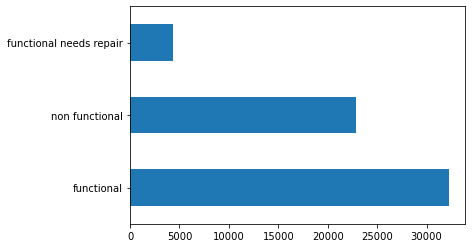

In [285]:
data_trimmed.target.value_counts().plot(kind='barh')

### There is a heavy imbalance because of the amount of functional pumps. The business problem addresses the financial weight that repairing water pumps causes. Therefore, it is the act of repairing and what might cause malfunctions that I am focusing on.  Because of this I will combine functional needs repair with non functional. This will help with class imbalance as well.

<AxesSubplot:>

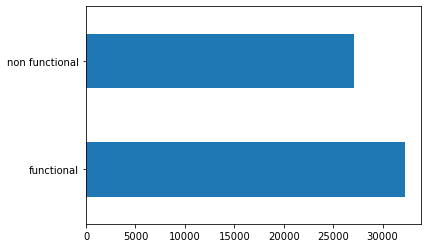

In [286]:
data_trimmed.target = data.target.apply(lambda target: 
                    'non functional' if target == 'functional needs repair'
                    else(target))

data_trimmed.target.value_counts().plot(kind='barh')

## Correlation between numeric data
### First I will make a numeric version of our target

In [287]:
data_trimmed['num_target'] = data_trimmed.target.apply(lambda target:
                                                      0 if target =='non functional'
                                                      else(1))


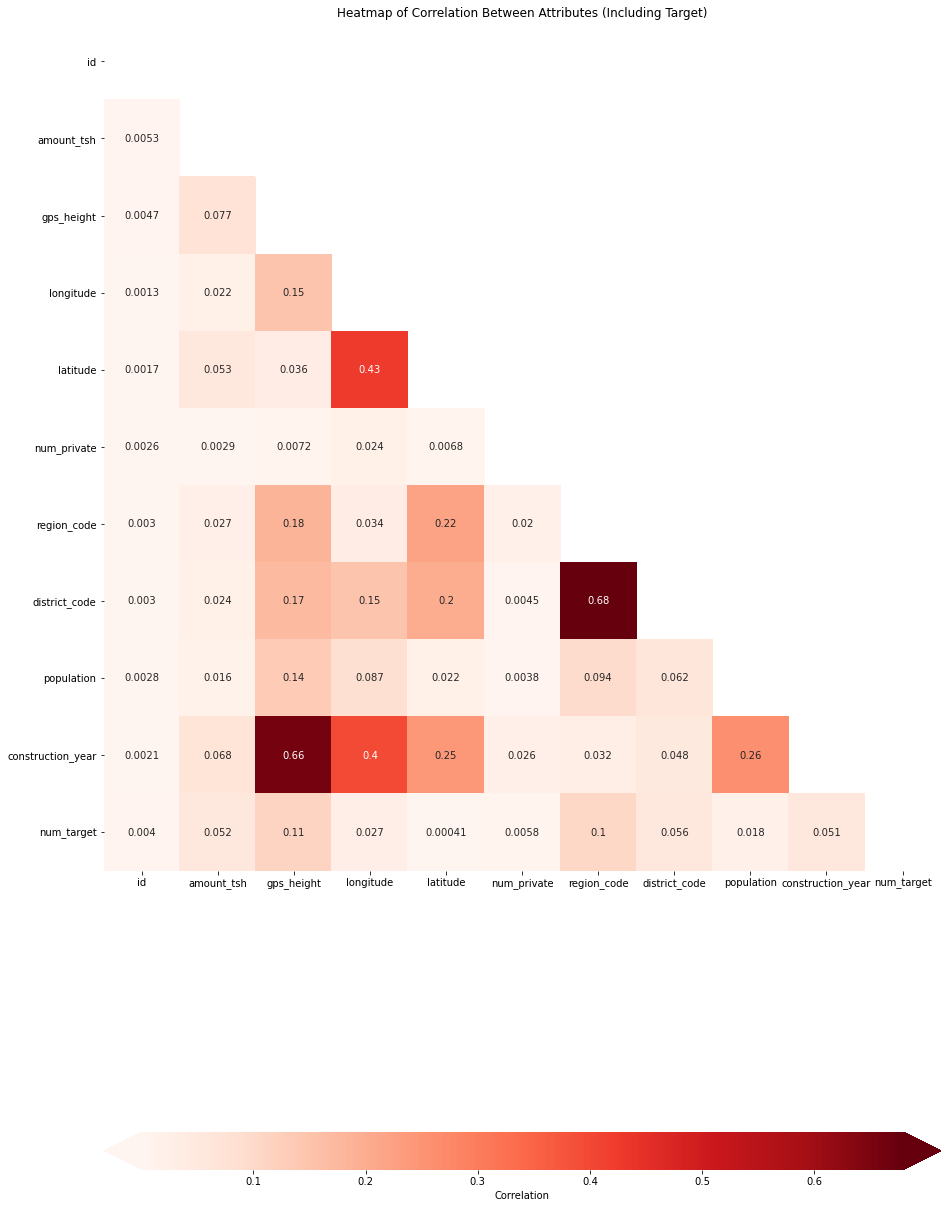

In [288]:
heatmap_data = data_trimmed.copy()
corr = heatmap_data.corr().abs()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 24))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    cmap='Reds',
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. 
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

#### GPS Height and region code are the most correlated to num_target.

### I will now see how GPS Height and region code affect the target

In [289]:
median_gps = data_trimmed.gps_height.median()

Text(0.5, 1.0, 'Target values when gps height < gps height median')

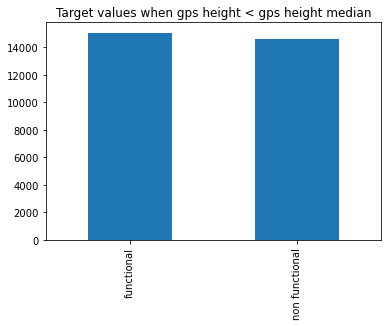

In [290]:
# Target value counts in bottom half of gps height values
data_trimmed.loc[data_trimmed.gps_height < median_gps].target.value_counts().plot(kind='bar')
plt.title('Target values when gps height < gps height median')

Text(0.5, 1.0, 'Target values when gps height > gps height median')

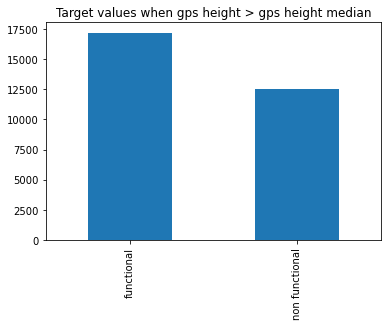

In [291]:
# Target value counts in top half of gps height values
data_trimmed.loc[data_trimmed.gps_height > median_gps].target.value_counts().plot(kind='bar')
plt.title('Target values when gps height > gps height median')

Text(0.5, 0, 'GPS Height')

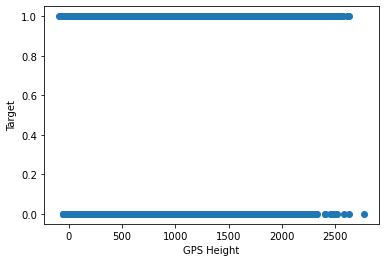

In [292]:
plt.scatter(y = data_trimmed.num_target, x = data_trimmed.gps_height)
plt.ylabel('Target')
plt.xlabel('GPS Height')

#### It appears that at higher altitudes there are less frequent non functional water pumps

### I will now investigate the relationship between region code and target. To do this I will see how many function vs non/functional water pumps exist per region

Ratio (func / non_func): 3.5808124459809854


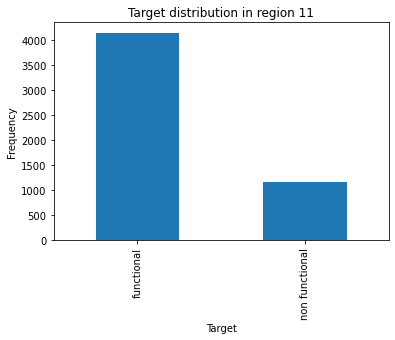

Ratio (func / non_func): 0.8180978762696214


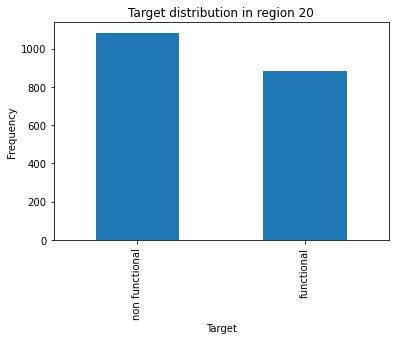

Ratio (func / non_func): 1.6560402684563758


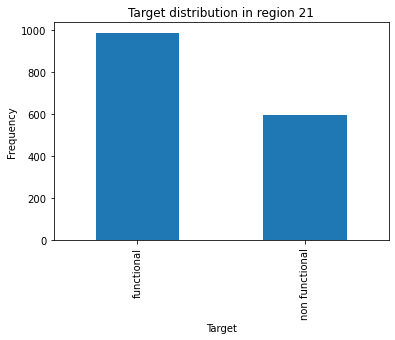

Ratio (func / non_func): 0.26832641770401106


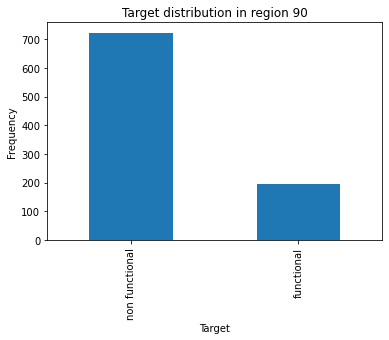

Ratio (func / non_func): 1.0840125391849529


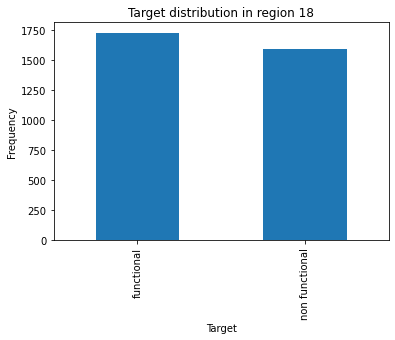

Ratio (func / non_func): 1.27420814479638


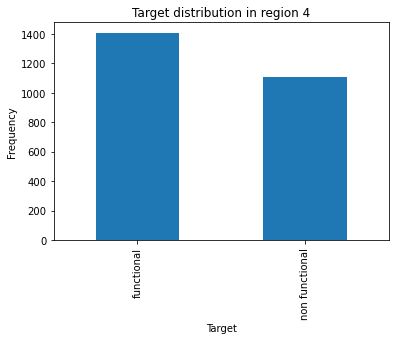

Ratio (func / non_func): 1.2735934664246824


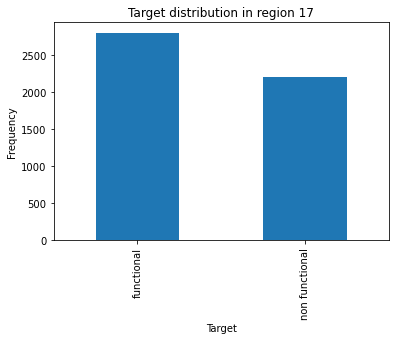

Ratio (func / non_func): 0.7717099373321397


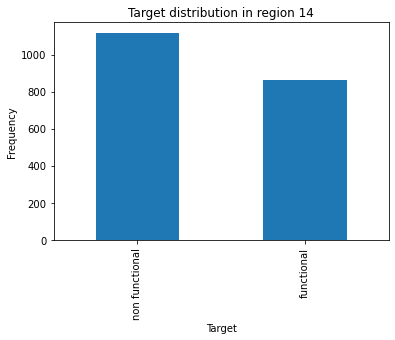

Ratio (func / non_func): 0.9158878504672897


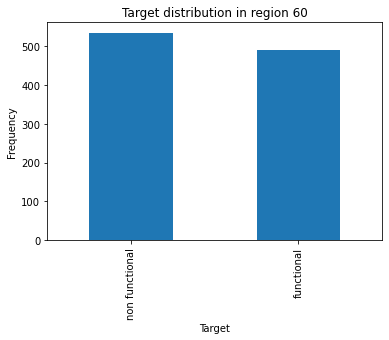

Ratio (func / non_func): 1.2758620689655173


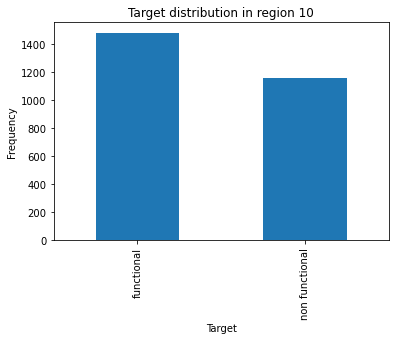

Ratio (func / non_func): 1.5181138585393905


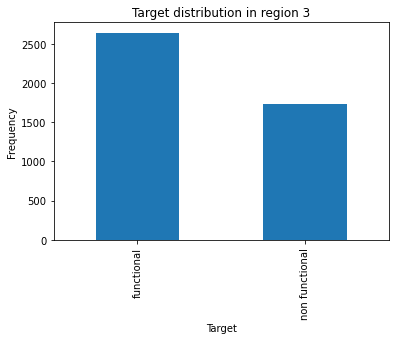

Ratio (func / non_func): 0.6421435059037239


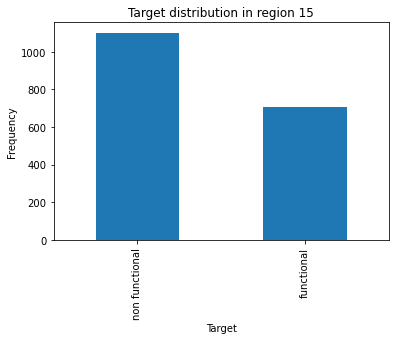

Ratio (func / non_func): 0.9297023432552248


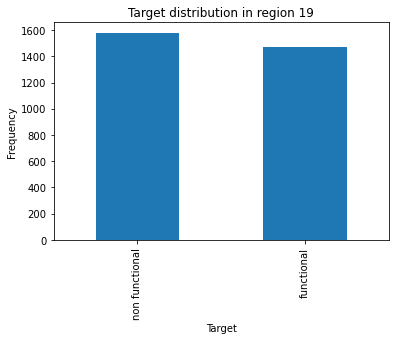

Ratio (func / non_func): 0.93805918788713


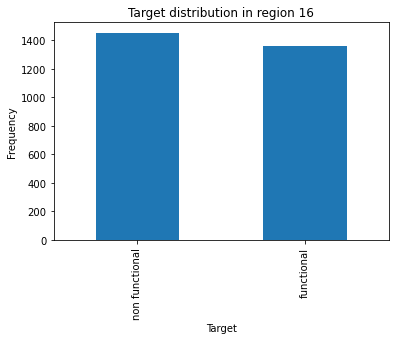

Ratio (func / non_func): 0.5359801488833746


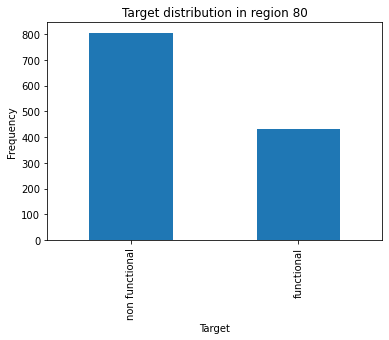

Ratio (func / non_func): 0.8464765100671141


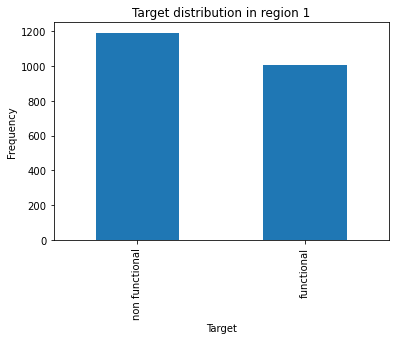

Ratio (func / non_func): 1.9631675874769798


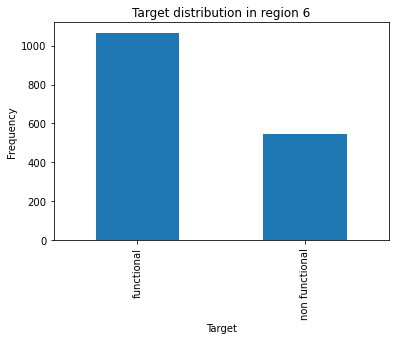

Ratio (func / non_func): 1.8910133843212238


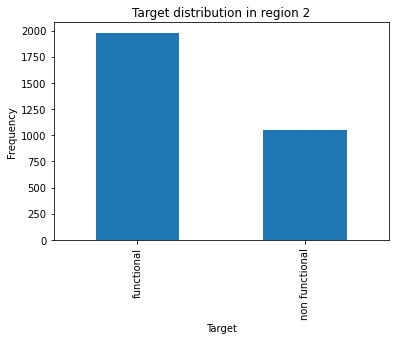

Ratio (func / non_func): 0.9995689655172414


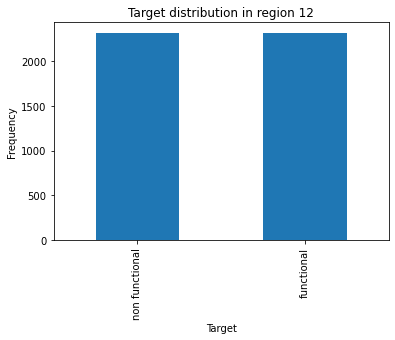

Ratio (func / non_func): 0.9343807763401109


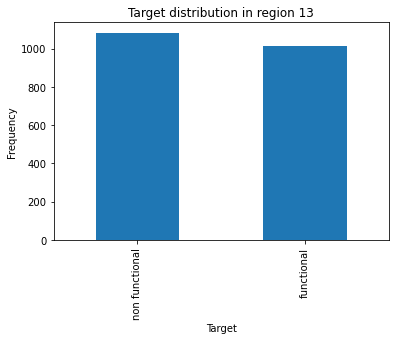

Ratio (func / non_func): 1.134178552562071


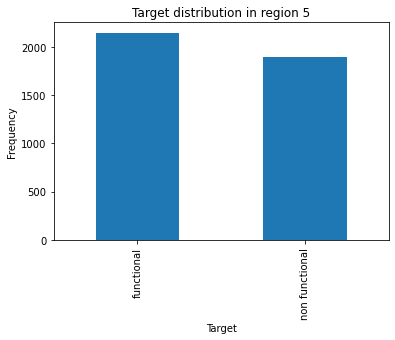

Ratio (func / non_func): 1.3401162790697674


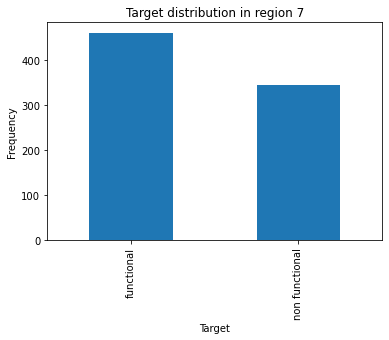

Ratio (func / non_func): 0.8232758620689655


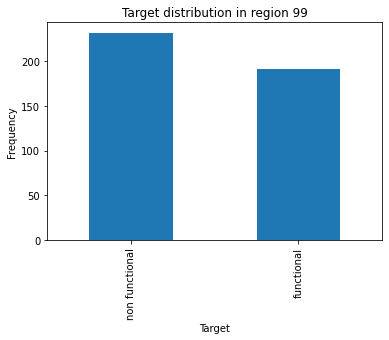

Ratio (func / non_func): 31.6


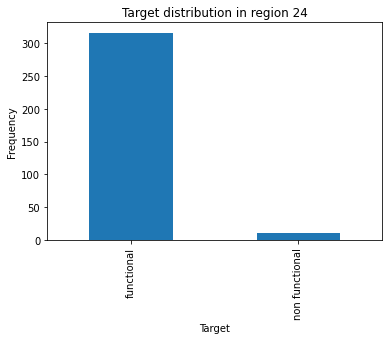

Ratio (func / non_func): 0.5537848605577689


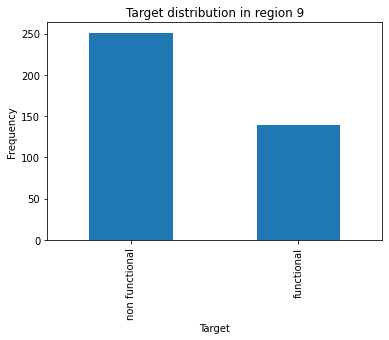

Ratio (func / non_func): 0.0948905109489051


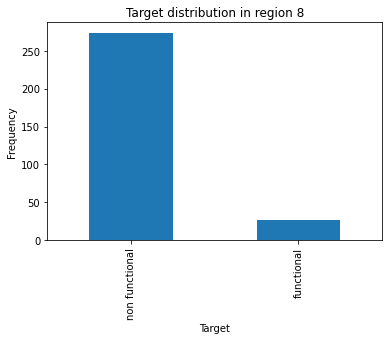

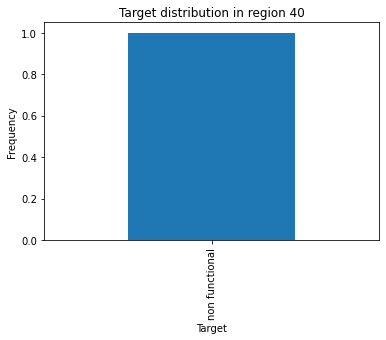

In [293]:
for region_code_ in data_trimmed.region_code.unique():
    v_counts = data_trimmed.loc[data_trimmed.region_code == region_code_].target.value_counts()
    v_counts.plot(kind='bar')   
    #Region 40 only has one non functional pump, so i will skip it
    if region_code_ != 40:
        #NOTE: The ratio metric below is a gain function i.e. higher scores are better
        print('Ratio (func / non_func): ' +str(v_counts['functional']/v_counts['non functional']))
    plt.title("Target distribution in region "+str(region_code_))
    plt.ylabel('Frequency')
    plt.xlabel('Target')
    plt.show()

#### There are many interesting insights to gain from this. Especially in the region that have higher non functional frequencies than functional. I will investigate the best  ratio region and the worst ratio region of our target. Ratio defined as functional_frequency / non_functional_frequency.
- Best Ratio: Region Code == 24
- Worst Ratio: Region Code == 8

<AxesSubplot:>

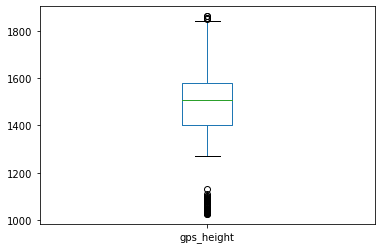

In [294]:
data_trimmed.loc[data_trimmed.region_code == 24].gps_height.plot(kind='box')

<AxesSubplot:>

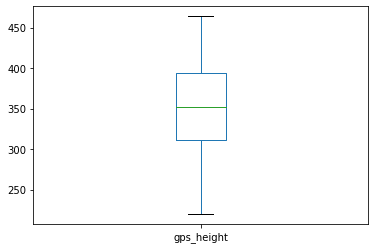

In [295]:
data_trimmed.loc[data_trimmed.region_code == 8].gps_height.plot(kind='box')

#### It is likely that the region code is strongly correlated due to gps height being similar per region

## Outliers

### Numeric Outliers

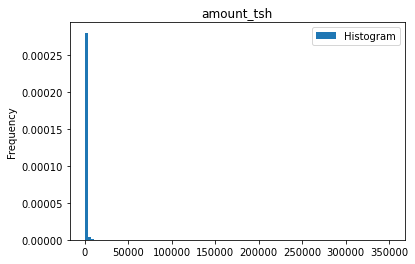

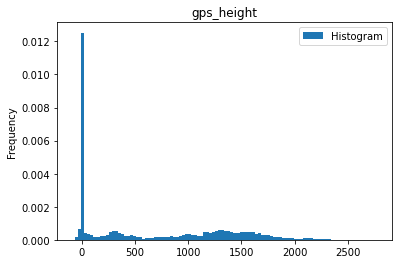

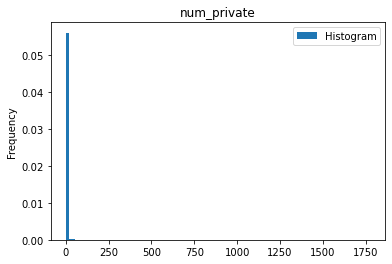

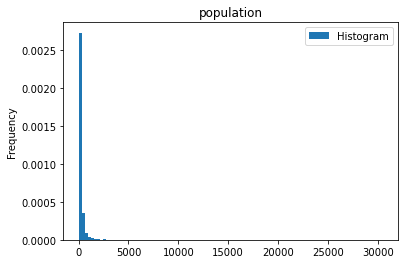

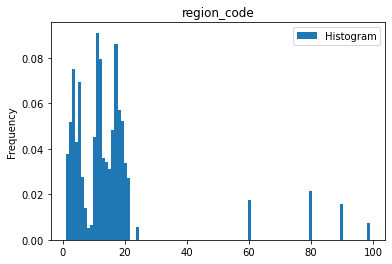

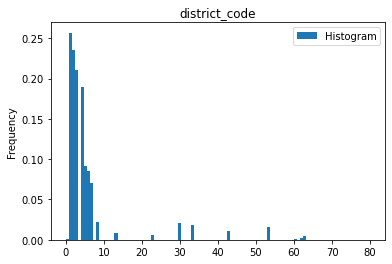

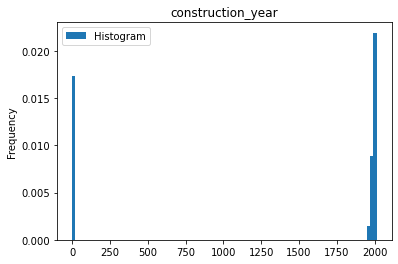

In [296]:
#Note: cols_to_change was made above and contains all numeric featrues in the data
binsize = 100
for col in cols_to_change:
    data_trimmed[col].plot.hist(density=True, bins=binsize,label='Histogram')
    
    plt.title(str(col))
    plt.legend()
    plt.show()

### Discrete Outliers

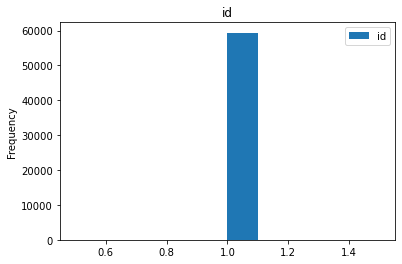

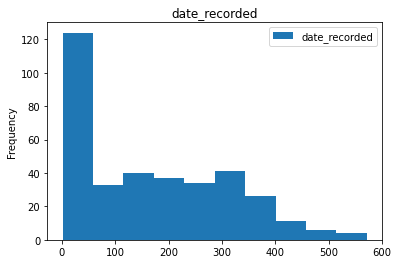

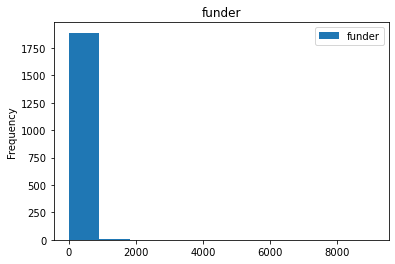

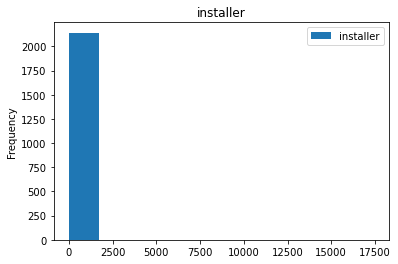

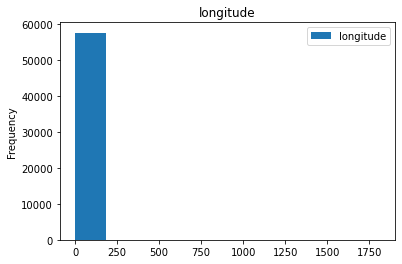

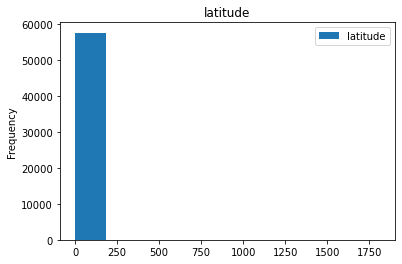

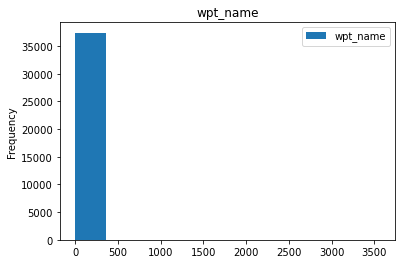

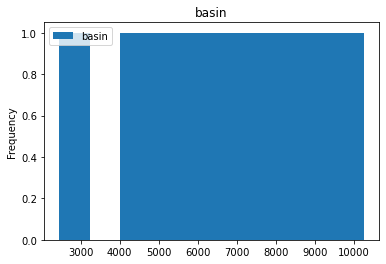

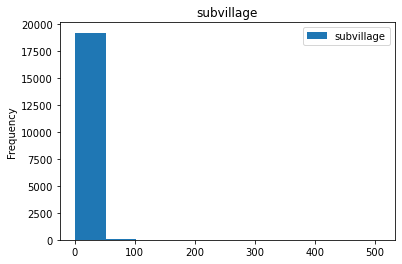

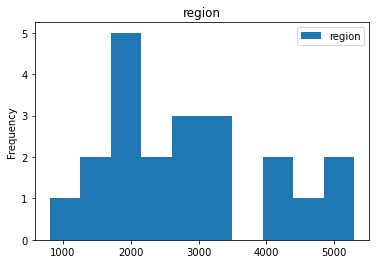

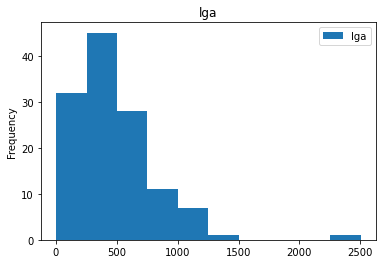

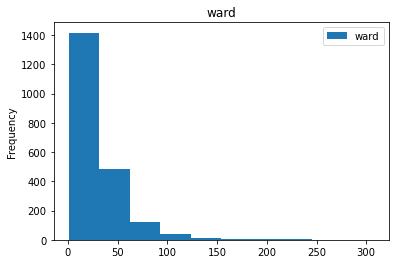

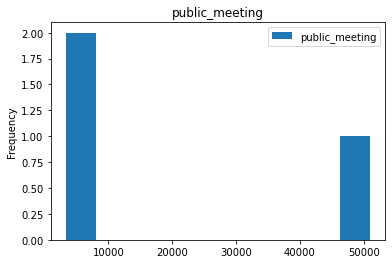

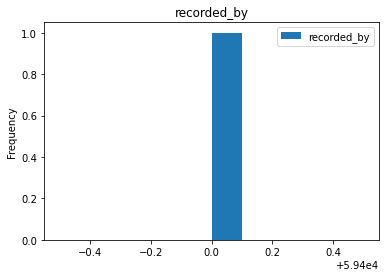

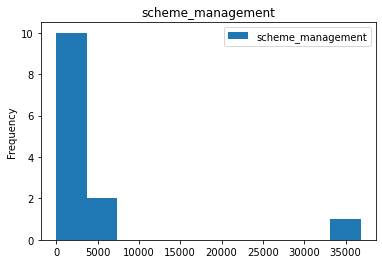

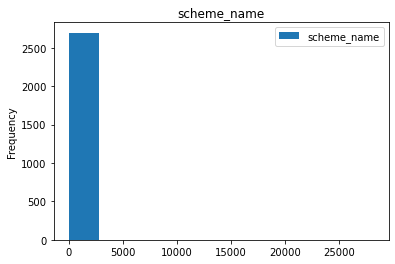

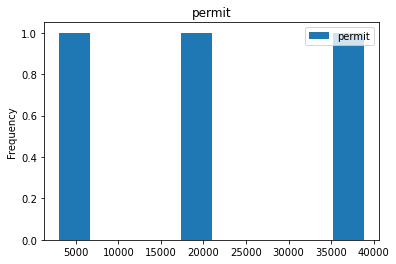

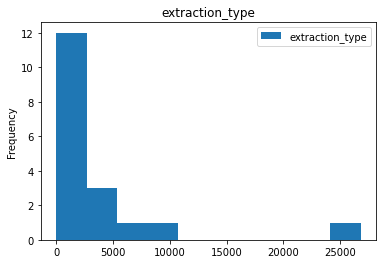

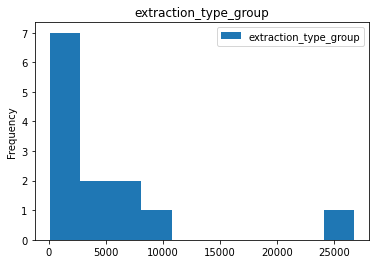

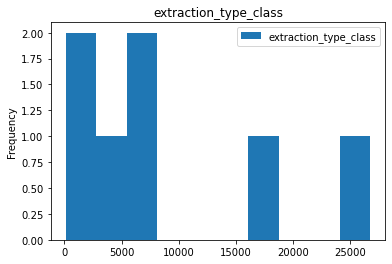

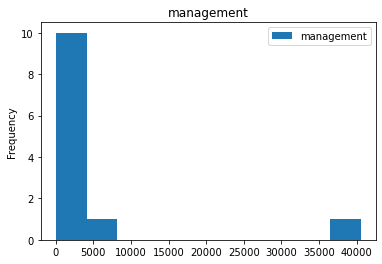

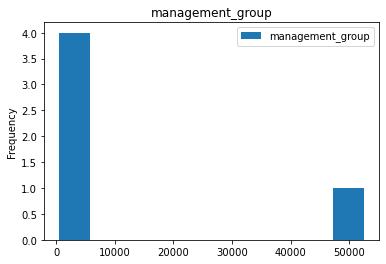

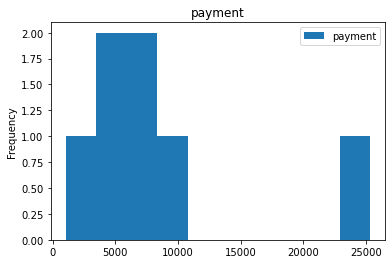

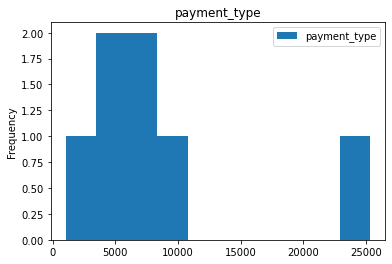

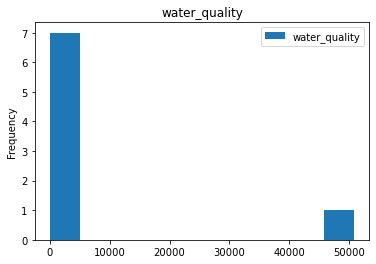

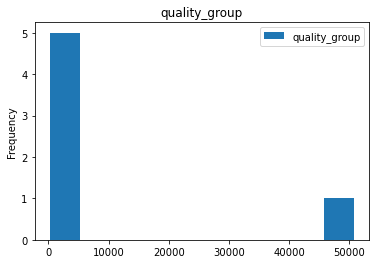

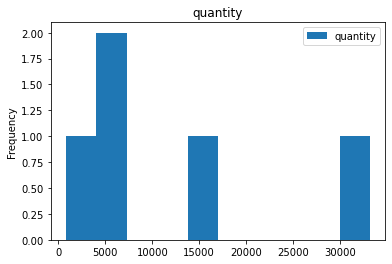

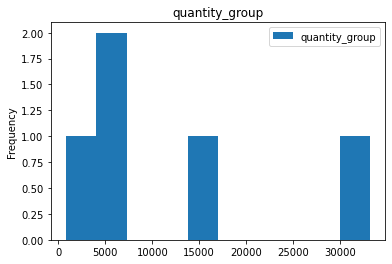

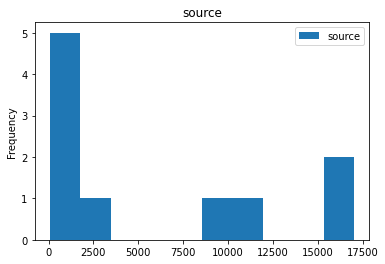

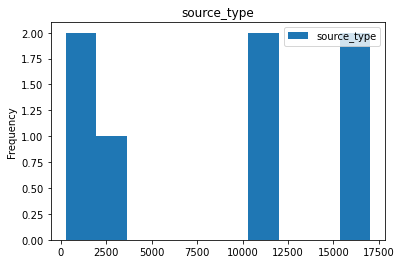

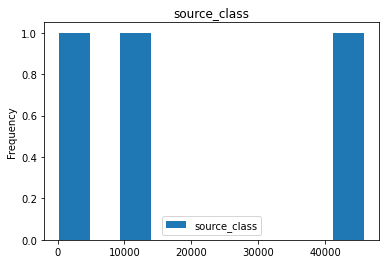

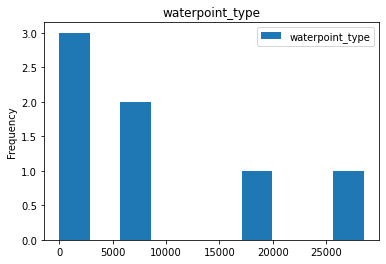

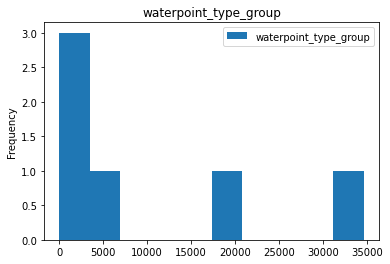

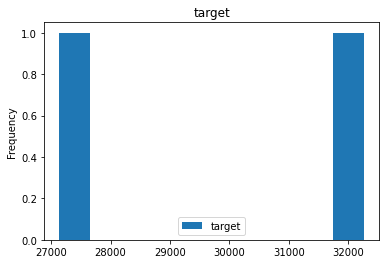

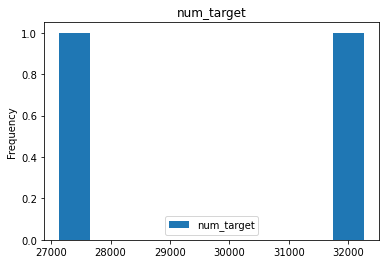

In [297]:
for col in data_trimmed.drop(columns=cols_to_change).columns:
    data_trimmed[col].value_counts().plot.hist()
    plt.title(str(col))
    plt.legend()
    plt.show()

# Data Preparation

#### Now I will need to remove outliers within categorical variables. This is so that when I train test split I am getting the same features in both X_train & X_test and to remove noise. What I am looking for is categorical features that contain categories that occur less than 25 times. If a certain category is happening less than 25 times I call it an outlier. This will also help remove outliers from the categorical variables for when we later One Hot Encode.

#### Explanation of code below:
The code below will look through the categorical columns in the data and find which ones
have value_count vals < 25. However, there are some columns that have too many small value counts.
If I were to remove all rows that contained a unique categorical value that occurs less 25 times I would
lose too much data. To prevent this, if the column has more than 50 value count values less than 25 I will
consider these columns to be useless.

In [298]:
trim_col_list = []
cols_to_drop = []
for col in data_trimmed.drop(columns=cols_to_change).columns:
    #Value Counts of column
    v_counts = data_trimmed[col].value_counts()
    #If there are values with less than 25 occurences
    if True in list(v_counts < 25):
        #If the values with less than 25 occurences occur less than 50 times
        if ((v_counts < 25).sum() < 50):         
            trim_col_list.append(col)
        #These columns have too many value_counts<25. Removing the values within
        #these columns would take away too much data
        else:
            cols_to_drop.append(col) 
#Our X data set will be build by substracting the cols_to_drop columns from data_trimmed
#So I will add the target column now
cols_to_drop.append('target')   
cols_to_drop.append('num_target')

In [299]:
trim_col_list

['lga',
 'scheme_management',
 'extraction_type',
 'water_quality',
 'waterpoint_type',
 'waterpoint_type_group']

In [300]:
cols_to_drop

['id',
 'date_recorded',
 'funder',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name',
 'target',
 'num_target']

In [301]:
# Before removing categorical outliers
data_trimmed.shape

(59400, 42)

In [302]:
#Removing occurences where value_count < 25 from the entire data frame
cut_off = 25
for col in trim_col_list:
    data_trimmed = remove_low_value_counts(data_trimmed, cut_off, col)

In [303]:
#After removing categorical outliers
data_trimmed.shape

(59351, 42)

# Train Test Split

In [304]:
X = data_trimmed.drop(columns=cols_to_drop)
y = data_trimmed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

 #### To start, I will use all possible features (keep in mind that I removed the features in cols_to_drop already)

## Categorical & Continuous

In [305]:
vanilla_categorical_columns = X_train.select_dtypes(object).columns
vanilla_numeric_columns =X_train.select_dtypes(int).columns

X_train_cat = X_train[vanilla_categorical_columns]
X_test_cat = X_test[vanilla_categorical_columns]

X_train_cont = X_train[vanilla_numeric_columns]
X_test_cont = X_test[vanilla_numeric_columns]

# OHE

In [306]:
ohe = OneHotEncoder(sparse=False)
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train_cat), columns = ohe.get_feature_names(vanilla_categorical_columns))
X_test_encoded = pd.DataFrame(ohe.transform(X_test_cat), columns = ohe.get_feature_names(vanilla_categorical_columns))

# Scale

In [307]:
#Scale
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_cont), columns=X_train_cont.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test_cont), columns = X_test_cont.columns)

# Concat

In [308]:
X_train_processed = pd.concat([X_train_encoded, X_train_scaled], axis = 1)
X_test_processed = pd.concat([X_test_encoded, X_test_scaled], axis = 1)

# Modeling

## Methodology:
### For this project I will be prioritizing the proportion of predicted non_functional that are actually positive. i.e. precision for non functional pumps. It is not as important to the business problem being able to detect functional water pumps. Precision is the prioritized metric for this project because I am trying to determine what causes a faulty pump. I will also keep in mind the recall of our predicted non functional pumps. Making a model with high precision means we are able to confidently determine if a pump is faulty. From this model I can derive which features are suggesting a faulty pump the most. By knowing which features are alluding to a faulty pump we can gain insight into what is causing pump failure. This information will allow organizations like the government of Tanzania to prevent pump failure thus saving money that would have been needed for maintenance and repair. 

## Logistic Regression (BASELINE)

In [309]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000)

In [315]:
cross_validate_model(lr, X_train_processed, y_train)

Train score:      0.7724035670440014
Test score: 0.7677531647222683


In [316]:
y_pred = lr.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.748     0.860     0.800      8047
non functional      0.799     0.657     0.721      6791

      accuracy                          0.767     14838
     macro avg      0.773     0.758     0.760     14838
  weighted avg      0.771     0.767     0.764     14838



array([[6922, 1125],
       [2332, 4459]])

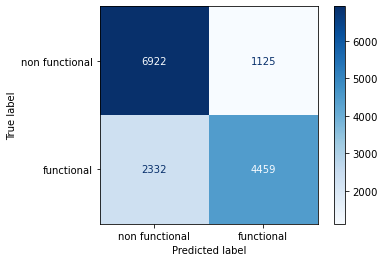

In [317]:
display_confusion_matrix(lr, X_test_processed, y_test)

### Model Analysis: 
This is a good baseline. I will be looking at accuracy of the model from the cross validation to get an idea if the model is overfit. Higher train scores from the cross_validate_model function imply an overfit model. I will also prioritize precision of non functional pumps but keep in mind recall and f1-score for future models. I will compare further models to the following metrics:
- Baseline Accuracy: .7677531647222683
- Baseline (Non Functional) Precision: .799
- Baseline (Non Functional) Recall: 0.657
- Baseline (Non Functional) F1: .721

## KNN Classifier

In [318]:
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

In [319]:
cross_validate_model(knn, X_train_processed, y_train)

Train score:      0.8402320624641577
Test score: 0.7850965218305694


In [330]:
y_pred = knn.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.786     0.832     0.809      8047
non functional      0.787     0.732     0.758      6791

      accuracy                          0.786     14838
     macro avg      0.786     0.782     0.783     14838
  weighted avg      0.786     0.786     0.786     14838



array([[21204,  2988],
       [ 4089, 16232]])

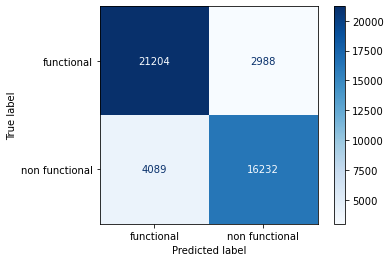

In [321]:
display_confusion_matrix(knn, X_test_processed, y_test)

### Model Analysis: 
- Baseline Accuracy: .7677531647222683
- Baseline (Non Functional) Precision: .799
- Baseline (Non Functional) Recall: 0.657
- Baseline (Non Functional) F1: .721

Despite having a higher accuracy score, it is abundantly clear from the cross validation that this model is overfit. This is likely causing the lower precision score. There is a higher recall score, but to meet the business problem I will consider the BASELINE model superior at this point.

## Bayes Classifier

### Naive Bayes

In [331]:
nb = GaussianNB()
nb.fit(X_train_processed, y_train)

GaussianNB()

In [332]:
cross_validate_model(nb, X_train_processed, y_train)

Train score:      0.7128816426800212
Test score: 0.7088491952747773


In [333]:
y_pred = nb.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.719     0.769     0.743      8047
non functional      0.702     0.643     0.671      6791

      accuracy                          0.712     14838
     macro avg      0.710     0.706     0.707     14838
  weighted avg      0.711     0.712     0.710     14838



array([[6191, 1856],
       [2421, 4370]])

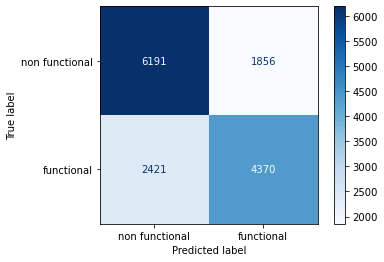

In [334]:
display_confusion_matrix(nb, X_test_processed, y_test)

### Model Analysis: 
- Baseline Accuracy: .7677531647222683
- Baseline (Non Functional) Precision: .799
- Baseline (Non Functional) Recall: 0.657
- Baseline (Non Functional) F1: .721

This model performed worse than the Baseline on all metrics. I will consider the BASELINE model superior at this point

### Bernoulli Naive Bayes

In [335]:
bnb = BernoulliNB()
bnb.fit(X_train_processed, y_train)

BernoulliNB()

In [336]:
cross_validate_model(bnb, X_train_processed, y_train)

Train score:      0.7120223352320758
Test score: 0.7096129095801821


In [337]:
y_pred = bnb.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.699     0.811     0.750      8047
non functional      0.723     0.585     0.647      6791

      accuracy                          0.708     14838
     macro avg      0.711     0.698     0.699     14838
  weighted avg      0.710     0.708     0.703     14838



array([[6524, 1523],
       [2816, 3975]])

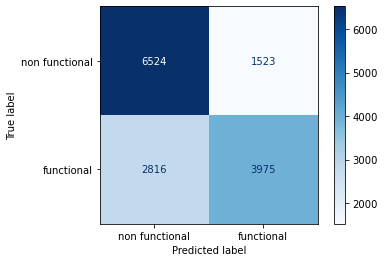

In [338]:
display_confusion_matrix(bnb, X_test_processed, y_test)

### Model Analysis: 

- Baseline Accuracy: .7677531647222683
- Baseline (Non Functional) Precision: .799
- Baseline (Non Functional) Recall: 0.657
- Baseline (Non Functional) F1: .721


This model performed worse than the Baseline on all metrics. I will consider the BASELINE model superior at this point.

## SVM

In [339]:
svm = svm.SVC()
svm.fit(X_train_processed, y_train)

SVC()

In [341]:
cross_validate_model(svm, X_train_processed, y_train)

Train score:      0.8083031994182892
Test score: 0.7920831807342286


In [342]:
y_pred = svm.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.764     0.890     0.822      8047
non functional      0.838     0.675     0.748      6791

      accuracy                          0.791     14838
     macro avg      0.801     0.782     0.785     14838
  weighted avg      0.798     0.791     0.788     14838



array([[7160,  887],
       [2208, 4583]])

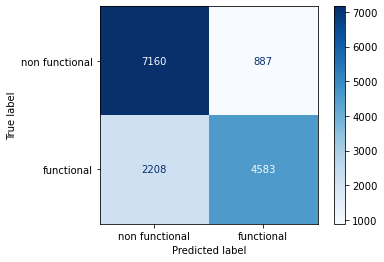

In [343]:
display_confusion_matrix(svm, X_test_processed, y_test)

### Model Analysis: 

- Baseline Accuracy: .7677531647222683
- Baseline (Non Functional) Precision: .799
- Baseline (Non Functional) Recall: 0.657
- Baseline (Non Functional) F1: .721

This model performed better on all metrics. I will now use this model's scores as the Baseline. Also, the fit time was 5 minutes, this could become troublesome when I need to optimize params. In the meantime, I will use tthe following scores to compare to further models.

- SVM Accuracy: .7920831807342286
- SVM (Non Functional) Precision: .799
- SVM (Non Functional) Recall: .838
- SVM (Non Functional) F1: .748 


## RandomForest

In [393]:
rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

In [345]:
cross_validate_model(rf, X_train_processed, y_train)

Train score:      0.9512726604272439
Test score: 0.8046863531014881


In [346]:
y_pred = rf.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.800     0.857     0.827      8047
non functional      0.815     0.745     0.779      6791

      accuracy                          0.806     14838
     macro avg      0.807     0.801     0.803     14838
  weighted avg      0.807     0.806     0.805     14838



array([[6898, 1149],
       [1729, 5062]])

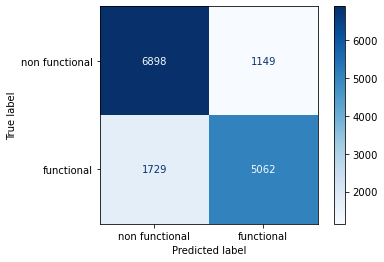

In [347]:
display_confusion_matrix(rf, X_test_processed, y_test)

### Model Analysis: 
- SVM Accuracy: .7920831807342286
- SVM (Non Functional) Precision: .799
- SVM (Non Functional) Recall: .838
- SVM (Non Functional) F1: .748 

This model has a higher accuracy, non functional f1, and non functional precision. The recall score is slightly worse. From the high difference in train score vs test score I assume this model is highly overfit. Because of the higher precision score, and knowing that I can prune the model later to mitigate the overfitness I will use these metrics as the new baseline.

- RF Accuracy: .8046863531014881
- RF (Non Functional) Precision: .815
- RF (Non Functional) Recall: .745
- RF (Non Functional) F1: .779

## XGBOOST

In [348]:
xg = XGBClassifier()
xg.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [349]:
cross_validate_model(xg, X_train_processed, y_train)

Train score:      0.8350762548395829
Test score: 0.8032036664262344


In [350]:
y_pred = xg.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.779     0.876     0.824      8047
non functional      0.828     0.705     0.761      6791

      accuracy                          0.798     14838
     macro avg      0.803     0.790     0.793     14838
  weighted avg      0.801     0.798     0.796     14838



array([[7050,  997],
       [2005, 4786]])

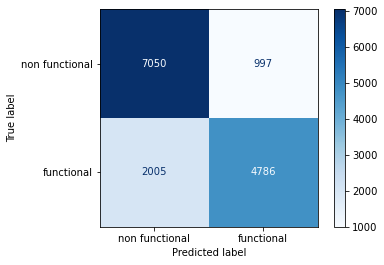

In [351]:
display_confusion_matrix(xg, X_test_processed, y_test)

### Model Analysis: 
- RF Accuracy: .8046863531014881
- RF (Non Functional) Precision: .815
- RF (Non Functional) Recall: .745
- RF (Non Functional) F1: .779


- XG Accuracy: .8032036664262344
- XG (Non Functional) Precision: .828
- XG (Non Functional) Recall: .705
- XG (Non Functional) F1: .705

This model is very close to the Random Forest model. The precision is higher, which is good. But, the cost of the recall is greater than the gain in precision. The XG model is also less overfit than the RF model so there will be less parameter optimization. I will use both of these models and compare the scores again after optimization

# Parameter Optimization

### Because the XtremeGradientBoosted and the RandomForest algorithm perfomed the best I will optimize their parameters using GridSearchCV

## GridSearch Round One (XGBOOST)

In [377]:
parameters = {
    'max_depth': range (0, 20, 5),
    'n_estimators': range (90, 110, 10),
    'learning_rate':  np.linspace(.1, 1, 10)   
}
xg = XGBClassifier()

In [378]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'precision_macro',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

In [379]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [380]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}

In [381]:
xg = XGBClassifier(learning_rate = .1,
                  max_depth = 15, n_estimators = 100)
xg.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [383]:
cross_validate_model(xg, X_train_processed, y_train)

Train score:      0.8933401456884132
Test score: 0.8121898028107071


In [382]:
y_pred = xg.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.792     0.886     0.836      8047
non functional      0.843     0.724     0.779      6791

      accuracy                          0.812     14838
     macro avg      0.817     0.805     0.807     14838
  weighted avg      0.815     0.812     0.810     14838



array([[7130,  917],
       [1877, 4914]])

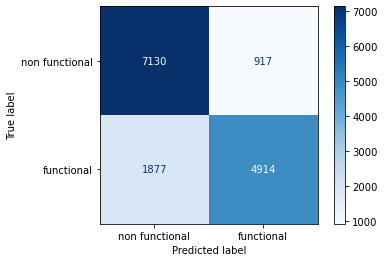

In [384]:
display_confusion_matrix(xg, X_test_processed, y_test)

#### Model Analysis

- Vanilla XG Accuracy: .8032036664262344
- Vanilla XG (Non Functional) Precision: .828
- Vanilla XG (Non Functional) Recall: .705
- Vanilla XG (Non Functional) F1: .705


- Optimized XG Accuracy: .8121898028107071
- Optimized XG (Non Functional) Precision: .853
- Optimized XG (Non Functional) Recall: .724
- Optimized XG (Non Functional) F1: .779

The optimized model is better on all metrics.

## GridSearch Round Two (RandomForest)

#### First, I will use a random CV search to determine a starting point for the GridSearchCV

In [440]:
parameters = {
    'max_depth': range (1, 20, 5),
    'n_estimators': range (90, 110, 5), 
    'max_features' : ['auto', 'sqrt'],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[ 2, 4, 6],
}
rf = RandomForestClassifier()


In [441]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = 3,
    cv = 3,
    verbose=True
)
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=3,
             param_grid={'max_depth': range(1, 20, 5),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(90, 110, 5)},
             scoring='f1_macro', verbose=True)

In [442]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [443]:
rf = RandomForestClassifier(max_depth =16, max_features='sqrt',min_samples_leaf=2,
                           min_samples_split=2, n_estimators=100)
rf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=16, max_features='sqrt', min_samples_leaf=2)

In [444]:
y_pred = rf.predict(X_test_processed)
print(classification_report(y_test, y_pred, digits=3))

                precision    recall  f1-score   support

    functional      0.754     0.914     0.826      8047
non functional      0.864     0.646     0.739      6791

      accuracy                          0.791     14838
     macro avg      0.809     0.780     0.783     14838
  weighted avg      0.804     0.791     0.786     14838



In [445]:
cross_validate_model(rf, X_train_processed, y_train)

Train score:      0.8253768489429026
Test score: 0.7949588203855564


#### Model Analysis

- Vanilla RF Accuracy: .8046863531014881
- Vanilla RF (Non Functional) Precision: .815
- Vanilla RF (Non Functional) Recall: .745
- Vanilla RF (Non Functional) F1: .779

- Optimized RF Accuracy: .7949588203855564
- Optimized RF (Non Functional) Precision: .864
- Optimized (Non Functional) Recall: .646
- Optimized RF (Non Functional) F1: .739

The optimized model did better with precision but worse in all of the other scores. The high substantial drop in recall is too much. At this point, I have determined that the final model will be the optimized XGBoostClassifer with the scores below:


- Optimized XG Accuracy: .8121898028107071
- Optimized XG (Non Functional) Precision: .853
- Optimized XG (Non Functional) Recall: .724
- Optimized XG (Non Functional) F1: .779

# Final Feature Selection
### Now that I have a validated model I will revisit which features are relevant or not. I will first remove features displaying collinearity and then I may remove features deemed unimportant by the model. For testing convenience, I will first develop the pipeline.

# Pipeline

In [450]:
xg = XGBClassifier(learning_rate = .1,
                  max_depth = 15, n_estimators = 100)
xg.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [473]:
importance_df = pd.DataFrame(xg.feature_importances_, columns=['importance'])
importance_df['feature_name'] = X_train_processed.columns
importance_df.loc[importance_df.importance == 0.0]

,importance,feature_name
62,0.0,lga_Kigoma Urban
156,0.0,recorded_by_GeoData Consultants Ltd
189,0.0,extraction_type_group_afridev
190,0.0,extraction_type_group_gravity
191,0.0,extraction_type_group_india mark ii
192,0.0,extraction_type_group_india mark iii
193,0.0,extraction_type_group_mono
194,0.0,extraction_type_group_nira/tanira
195,0.0,extraction_type_group_other
198,0.0,extraction_type_group_rope pump


#### It looks like the following features might not be important
 - quality_group
 - quantity_group
 - waterpoint_type
 - payment_type
 - extraction_type
#### I will now make an experimental feature list that is made up of the original features minus the above features. I will compare metrics of a model with each feature.

### I will use the og column names as the baseline and try different variations of combinations.

In [555]:
og_categorical_columns = X_train.select_dtypes(object).columns
og_numeric_columns =X_train.select_dtypes(int).columns

In [568]:
to_drop = ['quality_group',
          'quantity_group',
          'waterpoint_type',
          'payment_type',
          'extraction_type']
experimental_categorical_columns = []
# Loops through original columns and only add the column not in to_drop
for col in og_categorical_columns:
    if col in to_drop:
        pass
    else:
        experimental_categorical_columns.append(col)
    
experimental_numeric_columns = og_numeric_columns

In [569]:
#Transformer to transform original features
og_col_transformer = ColumnTransformer(

    transformers=[
        (  "ohe",
            OneHotEncoder(sparse=False),
           og_categorical_columns ),
        (
            'Scale',
            StandardScaler(),
            og_numeric_columns
        ) ],
    remainder="passthrough"
)

In [570]:
#Transformer to transform test features
experimental_col_transformer = ColumnTransformer(

    transformers=[
        (  "ohe",
            OneHotEncoder(sparse=False,handle_unknown='ignore'),
           experimental_categorical_columns),
        (
            'Scale',
            StandardScaler(),
            experimental_numeric_columns
        ) ],
    remainder="passthrough"
)

In [571]:
pipe_XG_og = Pipeline(

    steps=[("col_transformer", og_col_transformer),
        ('XG', xg)]
)

pipe_XG_experimental = Pipeline(

    steps=[("col_transformer", experimental_col_transformer),
        ('XG', xg)]
)


In [560]:
pipe_XG_og.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  Index(['basin', 'region', 'lga', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_qual...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=15,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_par

In [561]:
print('Original data')
cross_validate_model(pipe_XG_og, X_train, y_train)
y_pred = pipe_XG_og.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

Original data
Train score:      0.8933401456884132
Test score: 0.8121898028107071
                precision    recall  f1-score   support

    functional      0.792     0.886     0.836      8047
non functional      0.843     0.724     0.779      6791

      accuracy                          0.812     14838
     macro avg      0.817     0.805     0.807     14838
  weighted avg      0.815     0.812     0.810     14838



In [572]:
exp = experimental_categorical_columns
for col in experimental_numeric_columns:
    exp.append(col)
pipe_XG_experimental.fit(X_train[exp], y_train)


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'public_meeting',
                                                   'recorded_by',
                                                   'scheme_management',
                                                   'permit',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                              

In [574]:
print('Experimental data')
#cross_validate_model(pipe_XG_og, X_train[exp], y_train)
y_pred = pipe_XG_experimental.predict(X_test[exp])
print(classification_report(y_test, y_pred, digits=3))

Experimental data
                precision    recall  f1-score   support

    functional      0.789     0.881     0.833      8047
non functional      0.837     0.721     0.775      6791

      accuracy                          0.808     14838
     macro avg      0.813     0.801     0.804     14838
  weighted avg      0.811     0.808     0.806     14838



- Original XG (Non Functional) Precision: .843
- Original XG (Non Functional) Recall: .724
- Original XG (Non Functional) F1: .779


- Experimental XG (Non Functional) Precision: .837
- Experimental XG (Non Functional) Recall: .721
- Experimental XG (Non Functional) F1: .775

#### I will continue with the orignial data. 

# Final Model Evaluation

In [577]:
pipe_XG_og.fit(X_train, y_train)
y_pred = pipe_XG_og.predict(X_test)
print("Validation Accuracy Score:")
print(accuracy_score(y_test, y_pred))
# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

Validation Accuracy Score:
0.8116996899851732
                precision    recall  f1-score   support

    functional      0.792     0.886     0.836      8047
non functional      0.843     0.724     0.779      6791

      accuracy                          0.812     14838
     macro avg      0.817     0.805     0.807     14838
  weighted avg      0.815     0.812     0.810     14838



array([[7130,  917],
       [1877, 4914]])

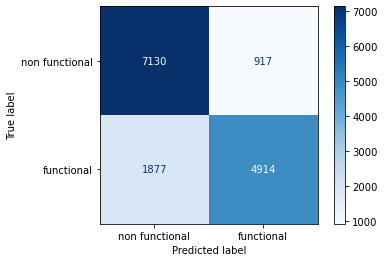

In [578]:
display_confusion_matrix(pipe_XG_og, X_test, y_test)

### Final Model Analysis
- 84.3% of our predicted non functional are actually non functional
- 72.4% of the non functional pumps were predicted
- This model will work for the feature importance analysis.

# Results

In [676]:
importance_df = pd.DataFrame(pipe_XG_og.steps[1][1].feature_importances_, columns=['importance'])
importance_df['feature_name'] = X_train_processed.columns
importance_df.sort_values(by=['importance'], ascending=False, inplace=True)

In [677]:
importance_df.loc[importance_df.importance > .01]

,importance,feature_name
253,0.273189,quantity_dry
288,0.108619,waterpoint_type_other
12,0.032655,region_Iringa
118,0.018903,lga_Ngara
55,0.014087,lga_Kahama
204,0.013675,extraction_type_class_motorpump
285,0.012312,waterpoint_type_communal standpipe multiple
209,0.010492,management_company


#### I will now investigate the above features to see what relationships exist with the target. I will look at the features in the following order:
- quantity_dry
- waterpoint_type_other
- region_Iringa

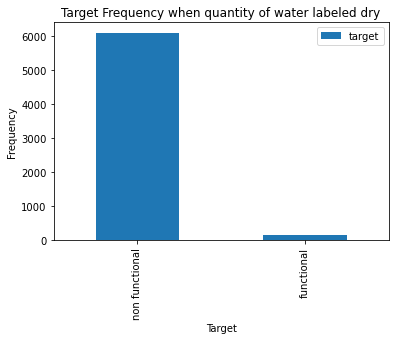

In [604]:
ax = data_trimmed.loc[data_trimmed.quantity == 'dry'].target.value_counts().plot(kind='bar')
ax.set_ylabel('Frequency')
ax.set_xlabel('Target')
ax.set_title('Target Frequency when quantity of water labeled dry')
ax.legend()

#### I can conclude that when the quantity of water is labeled as dry the water pump is no longer functional. The business recommendation from this will pertain to constructing pumps in areas where the water supply is strong. I will now investigate waterpoint_type_other.

In [611]:
data_trimmed.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'target', 'num_target'],
      dtype='object')

#### I am now going to look at point in the dataframe where waterpint_type = other and see if there are other relating characteristics. 

In [627]:
# Which organization are managing the waterpoint types where waterpoint_type is unknown
data_trimmed.loc[data_trimmed.waterpoint_type == 'other'].ward.value_counts()

Pangani Mashariki    51
Namajani             51
Diongoya             44
Vikindu              43
Marangu Mashariki    43
                     ..
Ilela                 1
Kihanga               1
Sekei                 1
Kinungu               1
Ruaruke               1
Name: ward, Length: 1162, dtype: int64

In [635]:
# Which organizations are managing where the waterpoint type is known
data_trimmed.loc[(data_trimmed.waterpoint_type != 'other')&
                 (data_trimmed.ward == 'Pangani Mashariki')].ward.value_counts()

Pangani Mashariki    13
Name: ward, dtype: int64

In [636]:
data_trimmed.loc[(data_trimmed.waterpoint_type != 'other')&
                 (data_trimmed.ward == 'Namajani')].ward.value_counts()

Namajani    13
Name: ward, dtype: int64

In [660]:
data_trimmed.loc[(data_trimmed.waterpoint_type != 'other')&
                 (data_trimmed.ward == 'Marangu Mashariki')].ward.value_counts()

Marangu Mashariki    8
Name: ward, dtype: int64

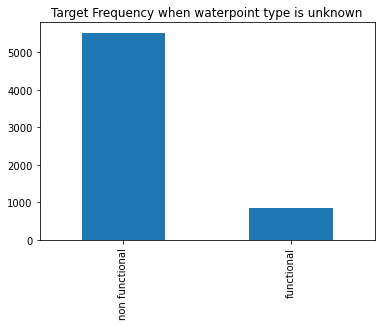

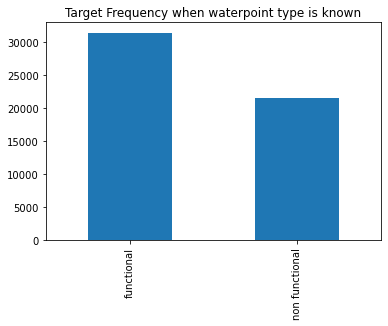

In [657]:
fig, ax = plt.subplots(figsize=(10,10))

plt.title('Target Frequency when waterpoint type is unknown')
ax_other = data_trimmed.loc[data_trimmed.waterpoint_type == 'other'].\
    target.value_counts().plot(kind='bar')
                                                                                            
plt.show()
plt.title('Target Frequency when waterpoint type is known')
ax_nother = data_trimmed.loc[data_trimmed.waterpoint_type != 'other'].target.value_counts().plot(kind='bar')
plt.show()

#### I have found 3 wards that have unknown data regarding waterpoint type. Investigating these wards and why their waterpoint sources will reduce the amount of pumps that need repair 


A Ward (Kata) is an administrative structure for one single town or portion of a bigger town

#### Waterpoint source within each of the wards:
- Marangu Mashariki (23,734 population)
    - Known waterpoint types: 8
    - Unknown waterpoint types: 43
- Namajani (13,739 population)
    - Known waterpoint types: 13
    - Unknown waterpoint types: 51
- Pangani Mashariki (54,025 population)
    - Known waterpoint types: 13
    - Unknown waterpoint types: 51

#### I will now investigate functionality for other features deemed important by the model. First I will see how the target behaves by region. I will determine how the target behaves by the ratio of funtional/non functional pumps. I.e. a higher score is better to the business problem and lower scoring regions are doing something costly.

In [683]:

for region in data_trimmed.region.unique():
    n_functional = data_trimmed.loc[data_trimmed.region == region]\
                                    .target.value_counts()['functional']
    n_non_functional = data_trimmed.loc[data_trimmed.region == region]\
                                    .target.value_counts()['non functional']
    ratio = n_functional/n_non_functional
    print('Region | Ratio')
    print(region, ratio)
    print()
    


Region | Ratio
Iringa 3.5915004336513445

Region | Ratio
Mara 0.8180978762696214

Region | Ratio
Manyara 1.6571428571428573

Region | Ratio
Mtwara 0.43449419568822556

Region | Ratio
Kagera 1.0875314861460956

Region | Ratio
Tanga 1.291253381424707

Region | Ratio
Shinyanga 1.2722704431247145

Region | Ratio
Tabora 0.7623762376237624

Region | Ratio
Pwani 1.443413729128015

Region | Ratio
Ruvuma 1.2758620689655173

Region | Ratio
Kilimanjaro 1.5181138585393905

Region | Ratio
Rukwa 0.6421435059037239

Region | Ratio
Mwanza 0.9393370856785491

Region | Ratio
Kigoma 0.9387052341597796

Region | Ratio
Lindi 0.42257462686567165

Region | Ratio
Dodoma 0.8464765100671141

Region | Ratio
Arusha 2.1744075829383887

Region | Ratio
Mbeya 0.9995689655172414

Region | Ratio
Singida 0.9343807763401109

Region | Ratio
Morogoro 1.1224814422057263

Region | Ratio
Dar es Salaam 1.345029239766082



#### The lowest scoring regions are Lindi & Mtwara. Before investigating further I am going to get the same ratio but for lga. LGA stands for Local Government Authority

In [709]:
low_val_lga = []
high_val_lga = []
for lga in data_trimmed.lga.unique():
    n_functional = data_trimmed.loc[data_trimmed.lga == lga]\
                                    .target.value_counts()['functional']
    n_non_functional = data_trimmed.loc[data_trimmed.lga == lga]\
                                    .target.value_counts()['non functional']
    ratio = n_functional/n_non_functional
    if ratio < .5:
        low_val_lga.append([lga, ratio])
        print('LGA | Ratio')
        print(lga, ratio)
        print()
    elif ratio > 2:
        high_val_lga.append([lga, ratio])
    

LGA | Ratio
Nanyumbu 0.3620689655172414

LGA | Ratio
Ukerewe 0.364

LGA | Ratio
Masasi 0.24235294117647058

LGA | Ratio
Dodoma Urban 0.32592592592592595

LGA | Ratio
Ruangwa 0.2175732217573222

LGA | Ratio
Misenyi 0.4772727272727273

LGA | Ratio
Bunda 0.4360655737704918

LGA | Ratio
Kiteto 0.30405405405405406

LGA | Ratio
Sikonge 0.4049586776859504

LGA | Ratio
Chunya 0.3185840707964602

LGA | Ratio
Newala 0.2692307692307692

LGA | Ratio
Tandahimba 0.37823834196891193

LGA | Ratio
Kilwa 0.4358974358974359

LGA | Ratio
Liwale 0.3391304347826087

LGA | Ratio
Rorya 0.3548387096774194

LGA | Ratio
Pangani 0.2719665271966527

LGA | Ratio
Nachingwea 0.0948905109489051

LGA | Ratio
Kigoma Urban 0.26785714285714285



In [710]:
name_low = []
name_high = []

for excerpt in low_val_lga:
    name_low.append(excerpt[0])
for excerpt in high_val_lga:
    name_high.append(excerpt[0])
    

In [696]:
data_trimmed.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'target', 'num_target'],
      dtype='object')

In [711]:
# List for gps heights where ratio is low
gps_low = []
# List for gps heights where ratio is high
gps_high = []


for lga in name_low:
    point = data_trimmed.loc[data_trimmed.lga == lga].gps_height.mean()
    gps_low.append(point)
    print('Name | Altitude')
    print(lga, point)
    print()
for lga in name_high:
    point = data_trimmed.loc[data_trimmed.lga == lga].gps_height.mean()
    gps_high.append(point)
    

Name | Altitude
Nanyumbu 314.4367088607595

Name | Altitude
Ukerewe 1197.3225806451612

Name | Altitude
Masasi 329.01325757575756

Name | Altitude
Dodoma Urban 0.0

Name | Altitude
Ruangwa 298.46048109965636

Name | Altitude
Misenyi 0.0

Name | Altitude
Bunda 1244.3561643835617

Name | Altitude
Kiteto 1336.3678756476684

Name | Altitude
Sikonge 0.0

Name | Altitude
Chunya 0.0

Name | Altitude
Newala 523.4978354978355

Name | Altitude
Tandahimba 278.71804511278197

Name | Altitude
Kilwa 71.3188775510204

Name | Altitude
Liwale 435.81168831168833

Name | Altitude
Rorya 1228.7095238095237

Name | Altitude
Pangani 23.049342105263158

Name | Altitude
Nachingwea 349.14

Name | Altitude
Kigoma Urban 824.4225352112676



In [712]:
print(len(gps_high))
np.mean(gps_high)

23


802.542334899863

In [713]:
print(len(gps_low))
np.mean(gps_low)

18


469.7013842117748

In [726]:
len(data_trimmed.lga.unique())

123

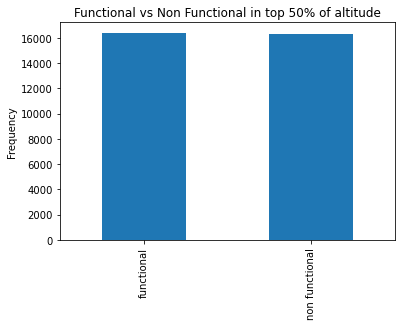

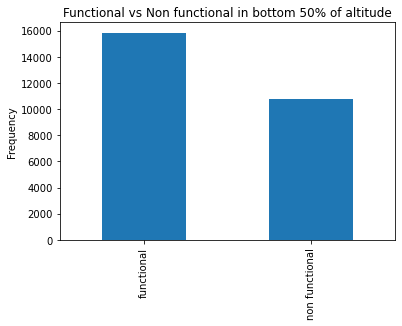

In [752]:
mean_gps = data_trimmed.gps_height.mean()

plt.ylabel('Frequency')
plt.title('Functional vs Non Functional in top 50% of altitude')
data_trimmed.loc[data_trimmed.gps_height < mean_gps].target.value_counts().plot(kind = 'bar')
plt.show()
plt.ylabel('Frequency')
plt.title('Functional vs Non functional in bottom 50% of altitude')
data_trimmed.loc[data_trimmed.gps_height > mean_gps].target.value_counts().plot(kind = 'bar')
plt.show()

#### The top 2% of lga in terms of ratio of functional to non functional water pumps have twice the altitude of the bottom 2% of lga's. From this observation we can conclude that water pumps need to build at the highest possible altitude to ensure longevity.


In [746]:
#Most important features to model
importance_df.head(6)

,importance,feature_name
253,0.273189,quantity_dry
288,0.108619,waterpoint_type_other
12,0.032655,region_Iringa
118,0.018903,lga_Ngara
55,0.014087,lga_Kahama
204,0.013675,extraction_type_class_motorpump


In [750]:
mean_gps

668.7376286835943

# Conclusions
### Based on the results we can confidently confirm the following conclusions:
    -All future water pumps build need a watersource that will not run out.
    -The following rural wards need aid in developing and recording waterpoint sources as they are top contributors to non functional water pumps.
        - Marangu Mashariki
        - Namajani
        - Pangani Mashariki
    -All future water pumps need to be built below 668m altitude when possible.
      

# Further Work
### Provided more time with this data, I am certain I can derive the following insights;
- How much does population affect demand for water and how does this demand affect pump functionality?
- What is the ideal extraction method>